In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
import xgboost
import xarray as xr
import numpy as np
from dask.distributed import Client
import dask
import dask_xgboost
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import time
from functools import partial
import multiprocessing
import os.path
from operator import is_not

In [4]:
processed_path = '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/'
path_to_labels = '/media/scottcha/E1/Data/OAPMLData/CleanedForecastsNWAC_CAIC_UAC.V1.csv'

In [5]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [5]:
#dask.config.set(scheduler='synchronous') 


In [7]:
#TODO set memory limit lower, then optimize chunks
client=Client(n_workers=8, threads_per_worker=1 )
client

Client Scheduler: tcp://127.0.0.1:33727 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 50.55 GB


In [ ]:
#try to concat each year/season


In [6]:
def lookup_forecast_region(label_region):
    if label_region == 'Mt Hood':
        return 'Mt Hood'
    elif label_region == 'Olympics':
        return 'Olympics'
    elif label_region == 'Cascade Pass - Snoq. Pass':
        return 'Snoqualmie Pass'
    elif label_region == 'Cascade Pass - Stevens Pass':
        return 'Stevens Pass'
    elif label_region == 'Cascade East - Central':
        return 'WA Cascades East, Central'
    elif label_region == 'Cascade East - North':
        return 'WA Cascades East, North'
    elif label_region == 'Cascade East - South':
        return 'WA Cascades East, South'
    elif label_region == 'Cascade West - Central':
        return 'WA Cascades West, Central'
    elif label_region == 'Cascade West - North':
        return 'WA Cascades West, Mt Baker'
    elif label_region == 'Cascade West - South':
        return 'WA Cascades West, South'
    elif label_region == 'Abajo':
        return 'Abajos'
    elif label_region == 'Logan':
        return 'Logan'
    elif label_region == 'Moab':
        return 'Moab'
    elif label_region == 'Ogden':
        return 'Ogden'
    elif label_region == 'Provo':
        return 'Provo'
    elif label_region == 'Salt Lake':
        return 'Salt Lake'
    elif label_region == 'Skyline':
        return 'Skyline'
    elif label_region == 'Uintas':
        return 'Uintas'
    elif label_region == 'Grand Mesa':
        return 'Grand Mesa Zone'
    elif label_region == 'Sangre de Cristo':
        return 'Sangre de Cristo Range'
    elif label_region == 'Steamboat & Flat Tops':
        return 'Steamboat Zone'
    elif label_region == 'Front Range':
        return 'Front Range Zone'
    elif label_region == 'Vail & Summit County':
        return 'Vail Summit Zone'
    elif label_region == 'Sawatch Range':
        return 'Sawatch Zone'
    elif label_region == 'Aspen':
        return 'Aspen Zone'
    elif label_region == 'Northern San Juan':
        return 'North San Juan Mountains'
    elif label_region == 'Southern San Juan':
        return 'South San Juan Mountains'
    elif label_region == 'Gunnison':
        return 'Gunnison Zone'
    else:
        return 'Got region ' + label_region + ' but its an unknown region'

In [7]:
regions = [#'Abajos', 'Logan', 'Moab', 'Ogden', 'Provo', 
           #'Salt Lake', 'Skyline', 'Uintas', 'Grand Mesa Zone', 
           'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
           'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
           'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone',
           'Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass',
           'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South',
           'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'
           ]

In [9]:
#maintaining this as a dict since the arrays are ragged and its more efficient this way
region_data = {}
for r in regions:
    region_data[r] = xr.open_dataset(processed_path + 'Region_' + r + '_20160101.nc')#, combine='nested', concat_dim='time')#, chunks={'season': 1, 'region': -1, 'latitude': 2, 'longitude': 2, 'var': -1, 'time': -1}).to_array()
    

In [9]:
region_data['Olympics']

<xarray.Dataset>
Dimensions:                                               (latitude: 10, longitude: 15, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] 2016-01-01
  * latitude                                              (latitude) float64 47.51 ... 48.04
  * longitude                                             (longitude) float64 -123.9 ... -123.0
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                

In [8]:
labels = pd.read_csv(path_to_labels, low_memory=False,
        dtype={'Day1Danger_OctagonAboveTreelineEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorth': 'object',
               'Day1Danger_OctagonAboveTreelineNorthEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorthWest': 'object',
               'Day1Danger_OctagonAboveTreelineSouth': 'object',
               'Day1Danger_OctagonAboveTreelineSouthEast': 'object',
               'Day1Danger_OctagonAboveTreelineSouthWest': 'object',
               'Day1Danger_OctagonAboveTreelineWest': 'object',
               'Day1Danger_OctagonBelowTreelineEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorth': 'object',
               'Day1Danger_OctagonBelowTreelineNorthEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorthWest': 'object',
               'Day1Danger_OctagonBelowTreelineSouth': 'object',
               'Day1Danger_OctagonBelowTreelineSouthEast': 'object',
               'Day1Danger_OctagonBelowTreelineSouthWest': 'object',
               'Day1Danger_OctagonBelowTreelineWest': 'object',
               'Day1Danger_OctagonNearTreelineEast': 'object',
               'Day1Danger_OctagonNearTreelineNorth': 'object',
               'Day1Danger_OctagonNearTreelineNorthEast': 'object',
               'Day1Danger_OctagonNearTreelineNorthWest': 'object',
               'Day1Danger_OctagonNearTreelineSouth': 'object',
               'Day1Danger_OctagonNearTreelineSouthEast': 'object',
               'Day1Danger_OctagonNearTreelineSouthWest': 'object',
               'Day1Danger_OctagonNearTreelineWest': 'object',
               'SpecialStatement': 'object',
               'image_paths': 'object',
               'image_types': 'object',
               'image_urls': 'object'})
date_col = 'Day1Date'
region_col = 'UnifiedRegion'
labels['parsed_date'] = pd.to_datetime(labels[date_col], format='%Y%m%d')
parsed_date_col = 'parsed_date'
metadata_cols = [date_col, region_col]
label_cols = ['Day1DangerBelowTreeline', 'Day1DangerNearTreeline', 'Day1DangerAboveTreeline']
labels[region_col] = labels.apply(lambda x : lookup_forecast_region(x[region_col]), axis=1)
labels = labels[labels[region_col]!='Unknown region']

In [9]:
labels = labels[labels[region_col].isin(regions)]

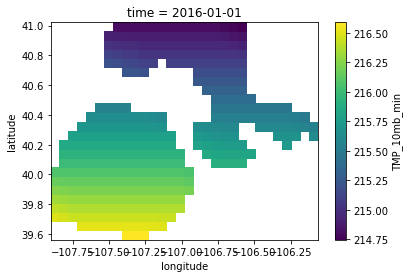

In [12]:
#this demonstrates wihtin a region how much data we have versus masked out areas
region_data['Steamboat Zone'].TMP_10mb_min.plot()

In [13]:
#find union of all lat/lon/region to just grids with values
#the process to filter the lat/lon is expensive but we need to do it here (30 seconds per region)
#as the helps the batch process select relevant data
lat_lon_union = pd.DataFrame()
for r in region_data.keys():
    print(r)
    region_df = region_data[r].stack(lat_lon = ('latitude', 'longitude')).lat_lon.to_dataframe()
    tmp_df = pd.DataFrame.from_records(region_df['lat_lon'], columns=['latitude', 'longitude'])
    indexes_to_drop = []
    for index, row in tmp_df.iterrows():
        #TODO: there might be a more efficient way than doing this one by one?
        if 0 == np.count_nonzero(region_data[r].to_array().sel(latitude=row['latitude'], longitude=row['longitude']).stack(time_var = ('time', 'variable')).dropna(dim='time_var', how='all').values):
            indexes_to_drop.append(index)
    tmp_df.drop(indexes_to_drop, axis=0, inplace=True)
    tmp_df[region_col] = r
    lat_lon_union = pd.concat([lat_lon_union, tmp_df])

Sangre de Cristo Range
Steamboat Zone
Front Range Zone
Vail Summit Zone
Sawatch Zone
Aspen Zone
North San Juan Mountains
South San Juan Mountains
Gunnison Zone
Mt Hood
Olympics
Snoqualmie Pass
Stevens Pass
WA Cascades East, Central
WA Cascades East, North
WA Cascades East, South
WA Cascades West, Central
WA Cascades West, Mt Baker
WA Cascades West, South


In [18]:
lat_lon_union.head()

,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,Cornices_OctagonAboveTreelineNorthEast,Cornices_OctagonAboveTreelineNorthWest,...,WindSlab_OctagonNearTreelineNorthWest,WindSlab_OctagonNearTreelineSouth,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date
UnifiedRegion,,,,,,,,,,,,,,,,,,,,,
Aspen Zone,39.043478,-107.256983,Aspen Zone,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,0,1,0,0,NaN,NaN,NaN,NaN,2013-12-23
Aspen Zone,39.043478,-107.256983,Aspen Zone,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,0,1,0,0,NaN,NaN,NaN,NaN,2013-12-24
Aspen Zone,39.043478,-107.256983,Aspen Zone,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,1,1,0,0,NaN,NaN,NaN,NaN,2013-12-25
Aspen Zone,39.043478,-107.256983,Aspen Zone,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,0,1,1,0,0,NaN,NaN,NaN,NaN,2013-12-26
Aspen Zone,39.043478,-107.256983,Aspen Zone,no-data,no-data,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,NaN,NaN,NaN,NaN,2013-12-27


In [14]:
#cache the data
lat_lon_union.to_csv(processed_path + 'lat_lon_union.csv')

In [10]:
lat_lon_union = pd.read_csv(processed_path + 'lat_lon_union.csv',float_precision='round_trip')

In [11]:
lat_lon_union.shape

(3367, 4)

In [12]:
lat_lon_union = lat_lon_union.set_index(region_col, drop=False).join(labels.set_index(region_col, drop=False), how='left', lsuffix='left', rsuffix='right')

In [13]:
lat_lon_union.shape

(2407398, 296)

In [13]:
del labels

In [14]:
def date_to_season(d):
    if d >= np.datetime64('2014-11-01') and d <= np.datetime64('2015-04-30'):
        return (np.datetime64('2014-11-01'), '14-15')
    elif d >= np.datetime64('2015-11-01') and d <= np.datetime64('2016-04-30'):
        return (np.datetime64('2015-11-01'), '15-16')
    elif d >= np.datetime64('2016-11-01') and d <= np.datetime64('2017-04-30'):
        return (np.datetime64('2016-11-01'), '16-17')
    elif d >= np.datetime64('2017-11-01') and d <= np.datetime64('2018-04-30'):
        return (np.datetime64('2017-11-01'), '17-18')
    elif d >= np.datetime64('2018-11-01') and d <= np.datetime64('2019-04-30'):
        return (np.datetime64('2018-11-01'), '18-19')
    elif d >= np.datetime64('2019-11-01') and d <= np.datetime64('2020-04-30'):
        return (np.datetime64('2019-11-01'), '19-20')
    else:
        print('Unknown season ' + str(d))
        return (-1,'Unknown')
    

In [18]:
#earliest_data, season = date_to_season(np.datetime64('2015-12-11'))

In [19]:
#remove unnecessary dimensions (like region)
#for k in region_data.keys():
#    region_data[k] = region_data[k].squeeze()

In [15]:
def create_filename_list(region, end_date, lookback_days):
    earliest_data, _ = date_to_season(end_date)
    filenames = []
    reg = region
    for i in range(lookback_days):
        d = np.datetime64(end_date) - np.timedelta64(i, 'D')
        if d < earliest_data:
            break #no more data
        filenames.insert(0,processed_path + 'Region_' + reg + '_' + pd.to_datetime(d).strftime('%Y%m%d') + '.nc')
    return filenames
        
        

In [9]:
region_keys = ['Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass', 'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South', 'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South']

In [14]:
i = 0
filenames = create_filename_list(region_keys[i], np.datetime64('2016-04-30'), 7)
ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='time', parallel=True, ).to_array()


In [18]:
ds2 = ds.chunk({'variable':-1, 'latitude': 1, 'longitude': 1, 'time': -1})

In [19]:
ds2.chunks

((978,), (5,), (1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1))

In [11]:
obj = ds2.to_netcdf(processed_path + 'Region_' + region_keys[i] + '_AllDates.nc', compute=False)

In [16]:
#obj.visualize(filename='transpose.svg')

In [10]:
xr.open_dataset(filenames[0])

<xarray.Dataset>
Dimensions:                                               (latitude: 5, longitude: 8, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] ...
  * latitude                                              (latitude) float64 ...
  * longitude                                             (longitude) float64 ...
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                         (time, latitude, longitude

In [21]:
d = np.datetime64('2016-03-01')

In [13]:
date_values_pd = pd.date_range(np.datetime64('2015-12-22') - np.timedelta64(7-1, 'D'), periods=7, freq="D")
date_values_pd

DatetimeIndex(['2015-12-16', '2015-12-17', '2015-12-18', '2015-12-19',
               '2015-12-20', '2015-12-21', '2015-12-22'],
              dtype='datetime64[ns]', freq='D')

In [22]:
filenames = create_filename_list('Steamboat Zone', d, 180)

In [23]:
filenames

['/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151101.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151102.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151103.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151104.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151105.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151106.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151107.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151108.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151109.nc',
 '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151110.nc',


In [27]:
os.path.isfile('/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151108.nc')

True

In [24]:
tmp_ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='time', parallel=True)#, chunks={'latitude': 1, 'longitude': 1, 'time': -1})

FileNotFoundError: [Errno 2] No such file or directory: b'/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/Region_Steamboat Zone_20151107.nc'

In [19]:
tmp_ds.chunks

Frozen(SortedKeysDict({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'latitude': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'longitude': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)}))

In [40]:
tmp_ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='time', parallel=True, chunks={'latitude': 1, 'longitude': 1})

In [41]:
tmp_ds.chunks

Frozen(SortedKeysDict({'time': (1, 1, 1, 1, 1, 1, 1), 'latitude': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'longitude': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)}))

In [45]:
tmp2 = tmp_ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)

In [50]:
a = tmp2.to_array().chunk({'variable': -1})

In [51]:
a.chunks

((978,), (1, 1, 1, 1, 1, 1, 1))

In [52]:
a.load()

<xarray.DataArray 'stack-afc7e83e2ec17eb4ee1d50a41dcede20' (variable: 978, time: 7)>
array([[-1.30618593e+00, -1.13812264e+00, -9.53191863e-01, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [-1.59120663e+00, -1.43821255e+00, -3.84966743e-01, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.98507463e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.02114903e+05,  1.02320959e+05,  1.01798404e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.64343124e+03,  5.68286950e+03,  5.71310465e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])
Coordinates:
    latitude   float64 47.51
    longitude  float64 -123.3
  * time       (time) datetime64[ns] 2016-02-24 2016-02-25 ... 2016-03-01
  * variable   (variable) <U52 'UGRD_planetaryboundarylayer_min' ... 'N5WAVH_...
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [31]:
def sel_lat_lon(ds):
    return ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)

def test_me5():
    data = []
    starttime = time.time()
    print('start' + str(time.time() - starttime))
    data = Parallel(n_jobs=14, backend="multiprocessing")(map(delayed(xr.open_dataset), filenames))
    print('sel ' + str(time.time() - starttime))
    
    filtered_data = Parallel(n_jobs=14, backend="multiprocessing")(map(delayed(sel_lat_lon), data))
    print('concat ' + str(time.time() - starttime))
    tmp_ds = xr.concat(filtered_data, dim='time')
    #tmp_ds = tmp_ds.chunk({'variable':-1, 'latitude': 1, 'longitude': 1, 'time': -1})
    
    #tmp2 = tmp_ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)
    tmp2 = tmp_ds.reset_index(dims_or_levels='time', drop=True).load()
    #tmp2.chunk({'time': -1}).load()
    #tmp3 = tmp2.to_array().load()
    #c = xr.concat([tmp2, tmp2], dim='sample')
    return tmp2

In [12]:
func = partial(xr.open_dataset, chunks={'latitude': 1, 'longitude': 1})
def test_me4():
    data = []
    print('start' + str(time.time()))
    data = Parallel(n_jobs=8, backend="multiprocessing")(map(delayed(func), filenames))
   
    print('files opened ' + str(time.time()))
    tmp_ds = xr.concat(data, dim='time')
    #tmp_ds = tmp_ds.chunk({'variable':-1, 'latitude': 1, 'longitude': 1, 'time': -1})
    print('sel ' + str(time.time()))
    tmp2 = tmp_ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    #tmp2.chunk({'time': -1}).load()
    #tmp3 = tmp2.to_array().load()
    #c = xr.concat([tmp2, tmp2], dim='sample')
    return tmp2

In [62]:
#this seems to be the fastest
def get_data(region, lat, lon, lookback_days, date):
    data = []
    filenames = create_filename_list(region, d, lookback_days)    
    data = Parallel(n_jobs=4, backend="multiprocessing")(map(delayed(xr.open_dataset), filenames))   
    tmp_ds = xr.concat(data, dim='time')   
    tmp2 = tmp_ds.sel(latitude=lat, longitude=lon)
    date_values_pd = pd.date_range(d - np.timedelta64(lookback_days-1, 'D'), periods=lookback_days, freq='D')
    tmp2 = tmp2.reindex({'time': date_values_pd})
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    
    return tmp2

In [53]:
def get_data_serial(region, lat, lon, lookback_days, date):
    data = []    
    filenames = create_filename_list(region, date, lookback_days) 
    for f in filenames:      
        if os.path.isfile(f): #sometimes the file is missing
            data.append(xr.open_dataset(f)) 
    try:
        tmp_ds = xr.concat(data, dim='time')
    except ValueError:
        print('Error On region: ' + region + ' and lat/lon: ' + str(lat) + '/' + str(lon) + ' and date: ' + str(date))
        return None
    
    tmp2 = tmp_ds.sel(latitude=lat, longitude=lon, method='nearest')
    date_values_pd = pd.date_range(date - np.timedelta64(lookback_days-1, 'D'), periods=lookback_days, freq='D')
    #reindex should fill missing values with NA
    tmp2 = tmp2.reindex({'time': date_values_pd})
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    #print("loaded data")
    return tmp2

In [61]:
def filter_lat_lon(ds):
    return ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)

In [14]:
def test_me():
    tmp_ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='time', parallel=True, chunks={'latitude': 1, 'longitude': 1})
    #tmp_ds = tmp_ds.chunk({'variable':-1, 'latitude': 1, 'longitude': 1, 'time': -1})
    tmp2 = tmp_ds.sel(latitude=47.507462686567166, longitude=-123.33734939759036)
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    #tmp2.chunk({'time': -1}).load()
    #tmp3 = tmp2.to_array().load()
    #c = xr.concat([tmp2, tmp2], dim='sample')
    return tmp2

In [19]:
#no dask, using dask runs out of memory
%time val = test_me()

CPU times: user 9min 9s, sys: 2min 2s, total: 11min 12s
Wall time: 7min 54s


In [20]:
%time val.to_array().values

CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 16.2 ms


array([[ 2.63118144e+00, -1.19187203e-01, -1.10681535e+00, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [ 1.36234490e+00, -1.60366839e+00, -7.66049270e-02, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 6.80453156e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.00569244e+05,  1.01167223e+05,  1.01566990e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.55955269e+03,  5.59523855e+03,  5.58331318e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [25]:
%time val2 = test_me2()

start
files opened
sel
CPU times: user 1min 49s, sys: 4.05 s, total: 1min 53s
Wall time: 1min 48s


In [26]:
%time val2.to_array().values

CPU times: user 15.9 ms, sys: 59 µs, total: 16 ms
Wall time: 14 ms


array([[ 2.63118144e+00, -1.19187203e-01, -1.10681535e+00, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [ 1.36234490e+00, -1.60366839e+00, -7.66049270e-02, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 6.80453156e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.00569244e+05,  1.01167223e+05,  1.01566990e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.55955269e+03,  5.59523855e+03,  5.58331318e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [27]:
%time val3 = test_me3()

start1588439690.0566068
files opened 1588439704.3993382
sel 1588439781.4505014
CPU times: user 1min 27s, sys: 5.04 s, total: 1min 32s
Wall time: 1min 34s


In [28]:
%time val3.to_array().values

CPU times: user 29.5 ms, sys: 0 ns, total: 29.5 ms
Wall time: 26.6 ms


array([[ 2.63118144e+00, -1.19187203e-01, -1.10681535e+00, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [ 1.36234490e+00, -1.60366839e+00, -7.66049270e-02, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 6.80453156e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.00569244e+05,  1.01167223e+05,  1.01566990e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.55955269e+03,  5.59523855e+03,  5.58331318e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [32]:
%time val5 = test_me5()

start2.384185791015625e-07
sel 12.02679705619812
concat 24.105298280715942
CPU times: user 1min 37s, sys: 5.77 s, total: 1min 43s
Wall time: 1min 42s


In [33]:
%time val5.to_array().values

CPU times: user 13.8 ms, sys: 3.78 ms, total: 17.6 ms
Wall time: 15.7 ms


array([[ 2.63118144e+00, -1.19187203e-01, -1.10681535e+00, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [ 1.36234490e+00, -1.60366839e+00, -7.66049270e-02, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 6.80453156e+02,  0.00000000e+00,  0.00000000e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.00569244e+05,  1.01167223e+05,  1.01566990e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.55955269e+03,  5.59523855e+03,  5.58331318e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [25]:
val2 = val.chunk({'time': -1})

In [31]:
val2.load().to_array().values

array([[-1.30618593e+00, -1.13812264e+00, -9.53191863e-01, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [-1.59120663e+00, -1.43821255e+00, -3.84966743e-01, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.98507463e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.02114903e+05,  1.02320959e+05,  1.01798404e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.64343124e+03,  5.68286950e+03,  5.71310465e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [32]:
val.load().to_array().values

array([[-1.30618593e+00, -1.13812264e+00, -9.53191863e-01, ...,
        -1.19120662e+00, -6.70562868e-01, -1.08034524e+00],
       [-1.59120663e+00, -1.43821255e+00, -3.84966743e-01, ...,
        -4.69789602e-01, -8.18180182e-01, -6.86998753e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.98507463e+00, ...,
         1.17964395e+01,  0.00000000e+00,  1.94209675e+01],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.02114903e+05,  1.02320959e+05,  1.01798404e+05, ...,
         1.01426822e+05,  1.02166590e+05,  1.00980050e+05],
       [ 5.64343124e+03,  5.68286950e+03,  5.71310465e+03, ...,
         5.60527027e+03,  5.61755451e+03,  5.59101838e+03]])

In [23]:
#val.data.visualize(filename='transpose.svg')

In [40]:
lat_lon_union.loc['Olympics'].iloc[0].longitude

-123.33734939759036

In [20]:
#tmp_ds.sel(longitude=-123.81927711)#, latitude=1)

In [ ]:
#TOOD: debug batch and review perf--currently error on duplicate date values

In [190]:


def process_sample(iter_tuple, lookback_days):
    row = iter_tuple[1]
    d = row[parsed_date_col] #row is a tuple which, 1 is the row
    
    lat = row['latitude']
    lon = row['longitude']
    reg = row[region_col]            
    ds = get_data_serial(reg, lat, lon, lookback_days, d)
    if ds is None:
        return None
    
    #print("actual data")
    if ds.time.shape[0] != lookback_days:    
        print('Need to drop! Error, incorrect shape on time ' + str(d))
    return ds



def get_xr_batch(labels, lookback_days=14, batch_size=64, y_column='Day1DangerAboveTreeline', n_jobs=-1):
    labels_data = labels
    
    X = None     
    y = None 

    first = True   
    num_in_place = 0
    
    while num_in_place < batch_size:
        if not first:
            #if we didn't meet the full batch size 
            #continue appending until its full
            #if num_in_place % 5 == 0:
            print('Filling remaining have ' + str(num_in_place))
            sample_size = batch_size-num_in_place
            if sample_size < 4:
                sample_size = 4
        else: 
            sample_size = batch_size
        
        #get 1/4 of the data from 'High' and 1/4 from low
        #this is basically a naive oversampling strategy since Low/High 
        #populations are much smaller that moderate/considerable
        #TODO: add Extreme in (or possibly make it high)
        batch_lookup_low = labels_data[labels_data[y_column]=='Low'].sample(int(sample_size/4), random_state=1)
        batch_lookup_moderate = labels_data[labels_data[y_column]=='Moderate'].sample(int(sample_size/4), random_state=1)
        batch_lookup_considerable = labels_data[labels_data[y_column]=='Considerable'].sample(int(sample_size/4), random_state=1)
        batch_lookup_high = labels_data[labels_data[y_column]=='High'].sample(int(sample_size/4), random_state=1)
        
        #remove moderate and considerable, keeping high and low to oversample them
        labels_data = labels_data.drop(batch_lookup_moderate.index, axis=0)
        labels_data = labels_data.drop(batch_lookup_considerable.index, axis=0)
        
        #sample frac=1 causes the data to be shuffled
        batch_lookup = pd.concat([batch_lookup_low,batch_lookup_moderate,batch_lookup_considerable,batch_lookup_high]).sample(frac=1)
        #print('lookup shape: ' + str(batch_lookup.shape))
        batch_lookup.reset_index(inplace=True, drop=True)
        func = partial(process_sample, lookback_days=lookback_days)
        #rewrite this to be parallel, returning the to_drop and the X
        data = Parallel(n_jobs=n_jobs, backend="multiprocessing")(map(delayed(func), batch_lookup.iterrows()))
        #pool = multiprocessing.Pool(8)
        #df_split = np.array_split(batch_lookup, len(batch_lookup))
        #data = (pool.map(func, df_split))
        #for _, row in batch_lookup.iterrows():
            #print('On: ' + str(_))
           
            
            #
            #print(date_values_pd)
            #ds = ds.reindex({'time': date_values_pd})
            
            #data = ds.sel(latitude=lat, longitude=lon).load()
            
            #reset the time index so we can align when concating
            #data = data.reset_index(dims_or_levels='time', drop=True)
            #if ds.time.shape[0] != lookback_days:    
            #    print('Error, incorrect shape on time ' + str(d))
            #    batch_lookup = batch_lookup.drop(_, axis=0)
            #    continue

            #this is a serious perf penalty, need to figure out a better way to do this
            #while keeping X and y aligned            
            #tmp = data.to_array().values.copy()            
            #tmp[tmp==0] = np.nan #in some cases there is only 0 data, setting 0 to nan to filter
            #if np.isnan(tmp).all():
            #    print('**In cleanup')
            #    #clean up any values which are all nan
            #    batch_lookup = batch_lookup.drop(_, axis=0)
            #    continue
            
            #data = data.drop_dims(['region', 'season'])
            #if first:
            #    X = ds
            #    first = False        
            #else:
            #    X = xr.concat([X, ds], dim='sample')
        #remove any None values and corresponding labels
        #usually from an error in the dataset 

        #print('data has len: ' + str(len(data)))
        to_delete = []
        for i in range(len(data)):
            #print('on i: ' + str(i))
            if data[i] is None:
                #print('deleting')
                to_delete.append(i)
                batch_lookup = batch_lookup.drop(i, axis=0)
                
        for d in to_delete:
            del data[d]
            
        if first and len(data) > 0:                            
            X = xr.concat(data, dim='sample', coords='all', compat='override')   
            y = batch_lookup
            first = False            
        elif not first and len(data) > 0:
            data.insert(0, X)
            X = xr.concat(data, dim='sample', coords='all', compat='override') 
            y = pd.concat([y, batch_lookup], axis=0)
            
        num_in_place = y.shape[0]
        #print('Num: ' + str(num_in_place))
                
    y = y.reset_index(drop=True)
            
    return X, y, labels_data







In [18]:
date_min = np.datetime64('2015-11-01')
date_max = np.datetime64('2017-04-30')
train_date_cutoff = np.datetime64('2017-03-01')


In [19]:
labels_data_union = lat_lon_union[lat_lon_union[parsed_date_col] >= date_min]
labels_data_union = labels_data_union[labels_data_union[parsed_date_col] <= date_max]
#copy so we can delete the overall data and only keep the filtered
labels_data_train = labels_data_union[labels_data_union[parsed_date_col] <= train_date_cutoff].copy()
labels_data_test = labels_data_union[labels_data_union[parsed_date_col] > train_date_cutoff].copy()


In [20]:
labels_data_train.reset_index(inplace=True)
labels_data_test.reset_index(inplace=True)

In [21]:
labels_data_train.shape

(807788, 297)

In [28]:
del lat_lon_union

In [29]:
import gc
gc.collect()

31

In [34]:
labels_data_train[region_col].value_counts()

Steamboat Zone                86184
Front Range Zone              86020
North San Juan Mountains      74655
WA Cascades West, South       67683
WA Cascades East, Central     59829
South San Juan Mountains      59768
WA Cascades East, North       58905
WA Cascades West, Central     44352
WA Cascades East, South       37653
Gunnison Zone                 36952
Sangre de Cristo Range        36208
WA Cascades West, Mt Baker    32802
Vail Summit Zone              29640
Aspen Zone                    26892
Sawatch Zone                  26355
Olympics                      24024
Mt Hood                        7392
Snoqualmie Pass                6699
Stevens Pass                   5775
Name: UnifiedRegion, dtype: int64

In [60]:
#with parallel file open but not parallel process sample
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 14, 64)

CPU times: user 11min 6s, sys: 1min 50s, total: 12min 56s
Wall time: 13min 29s


In [90]:
#8 cores
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 14, 64)

CPU times: user 16.1 s, sys: 3.17 s, total: 19.2 s
Wall time: 1min 47s


In [191]:
d = get_xr_batch(labels_data_train, 14, 64, n_jobs=14)

KeyboardInterrupt: 

In [150]:
d[9].ICSEV_400mb_min

<xarray.DataArray 'ICSEV_400mb_min' (time: 14)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    latitude   float64 48.8
    longitude  float64 -120.0
Dimensions without coordinates: time
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [159]:
d2 = xr.concat(d, dim='sample', coords='all', compat='override')#, join='outer')

In [162]:
d2.to_array().values.shape

(1125, 14, 63)

In [192]:
#14 coress
%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 14, 64, n_jobs=14)

Error On region: Steamboat Zone and lat/lon: 40.2/-107.44134078212291 and date: 2016-01-04 00:00:00
Filling remaining have 63
CPU times: user 21.1 s, sys: 6.15 s, total: 27.2 s
Wall time: 2min 13s


#14 cores, batch size of 12 is the max I can generate at once on my 48 gb machine
#though memory goes way down after returning so can concat these in multiple steps
#%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, 180, 12)

In [193]:
X_train

<xarray.Dataset>
Dimensions:                                               (sample: 67, time: 14)
Coordinates:
    longitude                                             (sample) float64 -105.5 ... -106.7
    latitude                                              (sample) float64 40.93 ... 37.46
Dimensions without coordinates: sample, time
Data variables:
    ICSEV_400mb_min                                       (sample, time) float64 0.0 ... 0.0
    HGT_1mb_max                                           (sample, time) float64 4.636e+04 ... 4.679e+04
    VGRD_7mb_avg                                          (sample, time) float64 -2.864 ... 0.6724
    O3MR_7mb_avg                                          (sample, time) float64 9.855e-06 ... 9.376e-06
    ICSEV_850mb_min                                       (sample, time) float64 nan ... nan
    RH_3mb_min                                            (sample, time) float64 0.04748 ... 0.01
    VGRD_1mb_min                                          (sample, time) float64 -22.94 ... 16.29
    UGRD_5mb_min                                          (sample, time) float64 0.5317 ... 28.52
    VGRD_1mb_avg                                          (sample, time) float64 -20.6 ... 19.72
    ICSEV_650mb_min                                       (sample, time) float64 0.8827 ... 1.0
    HGT_5mb_avg                                           (sample, time) float64 3.49e+04 ... 3.501e+04
    HGT_3mb_min                                           (sample, time) float64 3.827e+04 ... 3.843e+04
    ICSEV_700mb_min                                       (sample, time) float64 nan ... nan
    ICSEV_550mb_avg                                       (sample, time) float64 1.049 ... 1.552
    ICSEV_100mb_min                                       (sample, time) float64 0.0 ... 0.0
    VGRD_7mb_min                                          (sample, time) float64 -3.837 ... -3.169
    TMP_2mb_min                                           (sample, time) float64 241.4 ... 249.8
    UGRD_3mb_max                                          (sample, time) float64 22.66 ... 61.28
    VGRD_5mb_max                                          (sample, time) float64 -3.947 ... 10.92
    ICSEV_700mb_max                                       (sample, time) float64 nan ... nan
    RH_1mb_min                                            (sample, time) float64 0.001 ... 0.0009
    ICSEV_850mb_avg                                       (sample, time) float64 nan ... nan
    HGT_7mb_avg                                           (sample, time) float64 3.273e+04 ... 3.278e+04
    ICSEV_600mb_avg                                       (sample, time) float64 1.625 ... 1.255
    O3MR_1mb_min                                          (sample, time) float64 5.109e-06 ... 4.878e-06
    RH_5mb_avg                                            (sample, time) float64 0.4667 ... 0.09263
    O3MR_3mb_max                                          (sample, time) float64 1.077e-05 ... 1.042e-05
    RH_1mb_avg                                            (sample, time) float64 0.001075 ... 0.0009286
    ICSEV_450mb_min                                       (sample, time) float64 0.0 ... 0.1844
    ICSEV_350mb_min                                       (sample, time) float64 0.0 ... 0.0
    TMP_1mb_avg                                           (sample, time) float64 260.0 ... 259.4
    ICSEV_350mb_avg                                       (sample, time) float64 0.0 ... 0.0
    VGRD_3mb_avg                                          (sample, time) float64 -11.0 ... 12.6
    O3MR_5mb_avg                                          (sample, time) float64 1.08e-05 ... 1.028e-05
    ICSEV_300mb_min                                       (sample, time) float64 0.0 ... 0.0
    ICSEV_300mb_max                                       (sample, time) float64 0.0 ... 0.0
    ICSEV_900mb_max                                       (sample, time) float64 nan ... nan
    HGT_3mb_avg      

In [181]:
X_train.to_array().values.shape

(1125, 4, 14)

In [182]:
y_train.head()

,UnifiedRegion,Unnamed: 0,latitude,longitude,UnifiedRegionleft,Cornices_Likelihood,Cornices_MaximumSize,Cornices_MinimumSize,Cornices_OctagonAboveTreelineEast,Cornices_OctagonAboveTreelineNorth,...,WindSlab_OctagonNearTreelineNorthWest,WindSlab_OctagonNearTreelineSouth,WindSlab_OctagonNearTreelineSouthEast,WindSlab_OctagonNearTreelineSouthWest,WindSlab_OctagonNearTreelineWest,image_paths,image_types,image_urls,rose_url,parsed_date
0,Front Range Zone,1002,40.930435,-106.212291,Front Range Zone,no-data,no-data,no-data,no-data,no-data,...,no-data,no-data,no-data,no-data,no-data,NaN,NaN,NaN,NaN,2015-12-19
1,"WA Cascades East, North",353,48.820896,-120.024096,"WA Cascades East, North",no-data,no-data,no-data,no-data,no-data,...,1,1,1,1,1,NaN,NaN,NaN,NaN,2017-01-18
2,Gunnison Zone,192,38.982609,-106.826816,Gunnison Zone,no-data,no-data,no-data,no-data,no-data,...,0,1,1,0,0,NaN,NaN,NaN,NaN,2017-01-31
3,"WA Cascades East, South",122,46.492537,-121.168675,"WA Cascades East, South",no-data,no-data,no-data,no-data,no-data,...,1,1,1,1,1,NaN,NaN,NaN,NaN,2017-01-02
4,Front Range Zone,1013,40.930435,-105.536313,Front Range Zone,no-data,no-data,no-data,no-data,no-data,...,0,1,1,1,0,NaN,NaN,NaN,NaN,2015-11-21


In [194]:
y_train['Day1DangerAboveTreeline'].shape

(67,)

In [195]:
labels_data_train.shape

(807788, 297)

In [196]:
remaining_labels_train.shape

(807754, 297)

In [30]:
X_train.nbytes

14022656

In [85]:
#X_train

In [39]:
%time X_test, y_test, remaining_labels_test = get_xr_batch(labels_data_test, lookback_days=14, batch_size=128)

CPU times: user 11.1 s, sys: 1.08 s, total: 12.2 s
Wall time: 3min 2s


In [47]:
#X_test

In [35]:
client=Client(n_workers=8, threads_per_worker=1 )
client

Client Scheduler: tcp://127.0.0.1:38553 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 50.55 GB


In [46]:
%time X_train.to_netcdf('/media/scottcha/E1/Data/Temp/X_train.nc')


CPU times: user 1min 8s, sys: 5.94 s, total: 1min 14s
Wall time: 4min 17s


In [40]:
%time X_test.to_netcdf('/media/scottcha/E1/Data/Temp/X_test.nc')

CPU times: user 1.34 s, sys: 201 ms, total: 1.54 s
Wall time: 2.83 s


In [47]:
%time X_train = xr.open_dataset('/media/scottcha/E1/Data/Temp/X_train.nc', chunks={'time': -1})

CPU times: user 725 ms, sys: 27.8 ms, total: 753 ms
Wall time: 726 ms


In [48]:
X_train.chunks

Frozen(SortedKeysDict({'sample': (128,), 'time': (14,)}))

In [49]:
#TODO: write out file then read in with chunks to make this faster
%time X_train = X_train.interpolate_na('time')



CPU times: user 4min 56s, sys: 2.59 s, total: 4min 59s
Wall time: 4min 56s


In [41]:
X_test = X_test.chunk({'time':-1}).interpolate_na('time')

In [50]:
%time X_test = X_test.chunk({'time':-1}).interpolate_na('time')

CPU times: user 4min 55s, sys: 2.72 s, total: 4min 58s
Wall time: 4min 55s


In [81]:
#X_train

In [83]:
#X_train.to_array()

In [42]:
def xr_batch_to_tsfresh_df(xr_batch):
    xr_batch = xr_batch.to_array()
    xr_batch = xr_batch.dropna(dim='variable', how='all')
    stacked = xr_batch.stack(tsdata=('sample', 'time', 'variable')).to_dataframe().iloc[:,[-1]]
    stacked.columns = ['value']
    stacked.reset_index(inplace=True)
    stacked.columns = ['id', 'time', 'kind', 'value']
    stacked.dropna(how='any', inplace=True)
    return stacked

In [55]:
%time tsfresh_data = xr_batch_to_tsfresh_df(X_train)

CPU times: user 14.5 s, sys: 470 ms, total: 15 s
Wall time: 15.6 s


In [43]:
%time tsfresh_data_test = xr_batch_to_tsfresh_df(X_test)

CPU times: user 18 s, sys: 2.49 s, total: 20.5 s
Wall time: 17.4 s


In [58]:
tsfresh_data.to_csv('/media/scottcha/Data/Temp/GFSFiltered/training_tsfresh_data.csv')
y_train.to_csv('/media/scottcha/Data/Temp/GFSFiltered/y_train.csv')

In [44]:
tsfresh_data_test.to_csv('/media/scottcha/Data/Temp/GFSFiltered/test_tsfresh_data.csv')
y_test.to_csv('/media/scottcha/Data/Temp/GFSFiltered/y_test.csv')

In [4]:
import pandas as pd
tsfresh_data = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/training_tsfresh_data.csv')
y_train = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_train.csv')

In [5]:

tsfresh_data_test = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/test_tsfresh_data.csv')
y_test = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/y_test.csv')

In [60]:
import numpy as np
np.isnan(tsfresh_data['value']).any()

False

In [61]:
tsfresh_data = tsfresh_data[['id', 'time', 'kind', 'value']]

In [6]:
tsfresh_data.shape

(1709892, 5)

In [63]:
len(tsfresh_data['kind'].unique())

960

In [7]:
#TODO fix this earlier where its more performant
def clean_double_space(row):
    kind = row['kind']    
    kind = kind.replace('__', '_')
    row['kind'] = kind
    return row

In [8]:
%time tsfresh_data = tsfresh_data.apply(clean_double_space, axis=1)

CPU times: user 3min 50s, sys: 1.89 s, total: 3min 52s
Wall time: 3min 52s


In [64]:
tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].values[0:50])]

,id,time,kind,value
0,0,0,UGRD_planetaryboundarylayer_min,-0.878061
1,0,0,VGRD_planetaryboundarylayer_min,0.497159
2,0,0,VRATE_planetaryboundarylayer_min,0.000000
3,0,0,GUST_surface_min,1.234454
4,0,0,HGT_10mb_min,30740.691312
...,...,...,...,...
1719405,127,13,ABSV_100mb_min,0.000107
1719406,127,13,CLWMR_100mb_min,0.000000
1719407,127,13,O3MR_100mb_min,0.000002
1719408,127,13,HGT_150mb_min,13397.757901


In [65]:
tsfresh_data['id'].value_counts()

58     13428
89     13428
84     13404
80     13398
60     13398
       ...  
85     13356
87     13356
0      13356
106    13230
100    13230
Name: id, Length: 128, dtype: int64

In [12]:
from tsfresh import extract_relevant_features

In [13]:
relevant_features =[]

In [14]:
stride = 75
#TODO: make this more gracefully end on last stride
for i in range(0,len(tsfresh_data['kind'].values),stride):
    print('On i: ' + str(i))
    relevant_features.append( extract_relevant_features(tsfresh_data[tsfresh_data['kind'].isin(tsfresh_data['kind'].unique()[i:i+stride])], y_train['Day1DangerAboveTreeline'], column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))

On i: 0


Feature Extraction: 100%|██████████| 70/70 [00:55<00:00,  1.27it/s]


On i: 75


Feature Extraction: 100%|██████████| 70/70 [00:55<00:00,  1.27it/s]


On i: 150


Feature Extraction: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]


On i: 225


Feature Extraction: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]


On i: 300


Feature Extraction: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]


On i: 375


Feature Extraction: 100%|██████████| 70/70 [00:56<00:00,  1.24it/s]


On i: 450


Feature Extraction: 100%|██████████| 70/70 [00:58<00:00,  1.20it/s]


On i: 525


Feature Extraction: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]


On i: 600


Feature Extraction: 100%|██████████| 70/70 [00:57<00:00,  1.21it/s]


On i: 675


Feature Extraction: 100%|██████████| 70/70 [00:56<00:00,  1.23it/s]


On i: 750


Feature Extraction: 100%|██████████| 70/70 [00:57<00:00,  1.22it/s]


On i: 825


Feature Extraction: 100%|██████████| 70/70 [00:55<00:00,  1.26it/s]


On i: 900


Feature Extraction: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


On i: 975


ValueError: The following ids are in y but are missing inside the time series container: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}

In [ ]:
speak('done')

In [15]:
pd.concat(relevant_features, axis=1).to_csv('/media/scottcha/Data/Temp/GFSFiltered/train_revelant_features.csv')

In [17]:
relevant_features = pd.read_csv('/media/scottcha/Data/Temp/GFSFiltered/train_revelant_features.csv')

In [18]:
relevant_features.drop('id', axis=1, inplace=True)

In [19]:
y_train['Day1DangerAboveTreeline'].value_counts()

High            32
Considerable    32
Low             32
Moderate        32
Name: Day1DangerAboveTreeline, dtype: int64

In [20]:
from tsfresh import feature_extraction
feature_parameters = feature_extraction.settings.from_columns(relevant_features)

In [45]:
X_test.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [49]:
%time tsfresh_data_test = tsfresh_data_test.apply(clean_double_space, axis=1)

CPU times: user 3min 50s, sys: 1.93 s, total: 3min 51s
Wall time: 3min 51s


In [ ]:
tsfresh_data_test['id'].unique()

In [50]:
from tsfresh import extract_features
stride = 75
test_features_filtered = []
for i in range(0,len(tsfresh_data_test['kind'].values),stride):
    print('On i: ' + str(i))
    test_features_filtered.append( extract_features(tsfresh_data_test[tsfresh_data_test['kind'].isin(tsfresh_data_test['kind'].unique()[i:i+stride])], kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=14))


On i: 0


Feature Extraction: 100%|██████████| 70/70 [00:33<00:00,  2.11it/s]


On i: 75


Feature Extraction: 100%|██████████| 70/70 [00:30<00:00,  2.30it/s]


On i: 150


Feature Extraction: 100%|██████████| 70/70 [00:20<00:00,  3.37it/s]


On i: 225


Feature Extraction: 100%|██████████| 70/70 [00:27<00:00,  2.58it/s]


On i: 300


Feature Extraction: 100%|██████████| 70/70 [00:31<00:00,  2.25it/s]


On i: 375


Feature Extraction: 100%|██████████| 70/70 [00:33<00:00,  2.11it/s]


On i: 450


Feature Extraction: 100%|██████████| 70/70 [00:23<00:00,  3.03it/s]


On i: 525


Feature Extraction: 100%|██████████| 70/70 [00:23<00:00,  2.96it/s]


On i: 600


Feature Extraction: 100%|██████████| 70/70 [00:31<00:00,  2.19it/s]


On i: 675


Feature Extraction: 100%|██████████| 70/70 [00:32<00:00,  2.15it/s]


On i: 750


Feature Extraction: 100%|██████████| 70/70 [00:27<00:00,  2.57it/s]


On i: 825


Feature Extraction: 100%|██████████| 70/70 [00:22<00:00,  3.18it/s]


On i: 900


Feature Extraction: 100%|██████████| 70/70 [00:21<00:00,  3.23it/s]


On i: 975


ZeroDivisionError: division by zero

In [51]:
test_features_filtered = pd.concat(test_features_filtered, axis=1)

In [53]:
test_features_filtered.to_csv('/media/scottcha/Data/Temp/GFSFiltered/test_revelant_features.csv')

In [54]:
import xgboost as xgb
from xgboost import XGBClassifier

In [55]:
features_filtered = relevant_features

In [56]:
relevant_intersection = list(set(test_features_filtered.columns.values) & set(features_filtered.columns.values))

In [57]:
features_filtered[relevant_intersection].shape

(128, 139070)

In [58]:
grid = {'learning_rate': 0.1, 'objective': 'multi:softmax'}

model = XGBClassifier() 
model.set_params(**grid)



XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [59]:
val = model.fit(features_filtered[relevant_intersection], y_train['Day1DangerAboveTreeline'])

In [60]:
result = model.predict(test_features_filtered[relevant_intersection])

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
result.shape

(128,)

In [63]:
y_test['Day1DangerAboveTreeline'].shape

(128,)

In [64]:
#demonstrate we can produce results
#currently this is only one batch of 512 out of a close to a million row dataset
evaluateSingleClassShort(y_test['Day1DangerAboveTreeline'], result)

Accuracy: 0.328125
Classification Report
              precision    recall  f1-score   support

Considerable       0.31      0.47      0.38        32
        High       0.22      0.06      0.10        32
         Low       0.00      0.00      0.00        32
    Moderate       0.35      0.78      0.49        32

    accuracy                           0.33       128
   macro avg       0.22      0.33      0.24       128
weighted avg       0.22      0.33      0.24       128



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix
Confusion matrix, without normalization


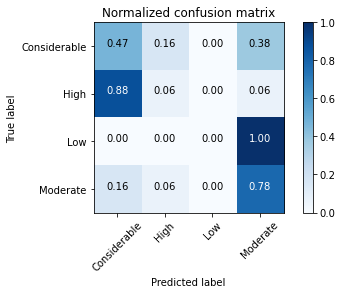

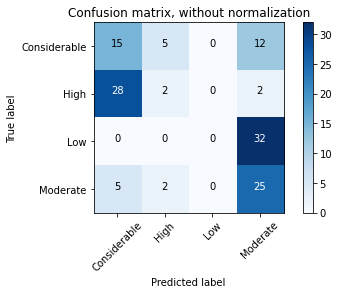

In [65]:
import numpy as np
cnf_matrix = confusion_matrix(y_test['Day1DangerAboveTreeline'], result)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

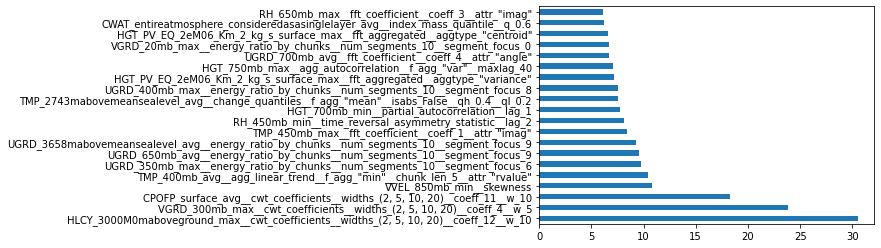

In [66]:
pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)[:20].plot.barh()